# EDA

In [12]:
! nvidia-smi

Thu Jan 19 08:46:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:06.0 Off |                    0 |
| N/A   26C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Libs

In [13]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchtext
from torchtext.legacy.data import Field, LabelField, Dataset, Example, BucketIterator

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords 
from collections import Counter

import string
import re
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Options

In [14]:
torchtext.__version__

'0.11.2'

In [15]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [16]:
SEED = 2023

torch.manual_seed(SEED)
torch.backends.cuda.deterministic = True

### Data

In [17]:
# ! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [18]:
base_csv = './data/imdb-dataset-of-50k-movie-reviews.zip'

In [19]:
df = pd.read_csv(base_csv)

In [20]:
label_dict = {
    'negative': 0,
    'positive': 1
}

In [21]:
df['label'] = df['sentiment'].map(label_dict)

In [22]:
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### Text Processing

In [85]:
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

In [86]:
def clean_text(text):
    """
    Series of cleaning. String to lower case, remove non words characters and numbers.
        text (str): input text
    return (str): modified initial text
    """
    text = text.lower()  # lowercase text
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

In [87]:
def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    """
    Lemmatize, tokenize, crop and remove stop words.
    """
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence, language='english')]
    else:
        tokens = [w for w in word_tokenize(sentence, language='english')]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    return tokens   

In [88]:
def clean_sentences(df, column):
    """
    Remove irrelavant characters (in new column clean_sentence).
    Lemmatize, tokenize words into list of words (in new column tok_lem_sentence).
    """
    print('Cleaning sentences...')
    df['clean_sentence'] = df[column].apply(clean_text)
    df['tok_lem_sentence'] = df['clean_sentence'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True))
    return df

In [89]:
df_clean = clean_sentences(df, column='review')

Cleaning sentences...


In [91]:
df_clean.head()

,review,sentiment,label,clean_sentence,tok_lem_sentence
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewer, ha, mentioned,..."
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production br br the...,"[a, wonderful, little, production, br, br, the..."
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...,"[i, thought, this, wa, a, wonderful, way, to, ..."
3,Basically there's a family where a little boy ...,negative,0,basically there a family where a little boy ...,"[basically, there, a, family, where, a, little..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love in the time of money is ...,"[petter, mattei, love, in, the, time, of, mone..."


In [92]:
df_clean = df_clean.rename(columns={
    'clean_sentence': 'text',
    'label': 'target'
})

In [93]:
columns = ['text', 'target']

In [94]:
train_df, valid_df = train_test_split(df_clean[columns], random_state=SEED, test_size=0.2, shuffle=True)

In [95]:
len(train_df)

40000

In [96]:
len(valid_df)

10000

In [97]:
class DataFrameDataset2(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                                 "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [99]:
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
# to use DataFrame as a Data source

class DataFrameDataset(Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [100]:
TEXT = Field(tokenize='spacy', batch_first=True, include_lengths=True, tokenizer_language='en_core_web_sm')
LABEL = LabelField(dtype=torch.float, batch_first=True)

In [105]:
fields = [('text', TEXT), ('target', LABEL)]

In [106]:
train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

In [107]:
MAX_VOCAB_SIZE = 25000

In [108]:
TEXT.build_vocab(train_ds, max_size=MAX_VOCAB_SIZE, vectors='glove.6B.200d', unk_init = torch.Tensor.zero_) 
LABEL.build_vocab(train_ds)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                               
100%|█████████▉| 399999/400000 [00:34<00:00, 11561.97it/s]


In [109]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [127]:
device

device(type='cuda')

In [113]:
train_iterator, valid_iterator = BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device
)

### LSTM

### Hyperparameters

In [114]:
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

### LSTM class

In [116]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [117]:
model = LSTM_net(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

### Loading the pretrained vectors into the embedding matrix

In [118]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([25002, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0130, -0.6173,  0.3216,  ...,  0.5308, -0.3669, -0.5871],
        [ 0.5857, -0.3048, -0.4439,  ..., -0.0661,  0.3639, -0.2699],
        [ 0.1153, -0.3457,  0.0913,  ..., -0.3152,  0.4203,  0.4409]])

In [119]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0130, -0.6173,  0.3216,  ...,  0.5308, -0.3669, -0.5871],
        [ 0.5857, -0.3048, -0.4439,  ..., -0.0661,  0.3639, -0.2699],
        [ 0.1153, -0.3457,  0.0913,  ..., -0.3152,  0.4203,  0.4409]])


In [120]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [128]:
print(model)

LSTM_net(
  (embedding): Embedding(25002, 200, padding_idx=1)
  (rnn): LSTM(200, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [121]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [143]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [144]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [145]:
t = time.time()
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
print(f'time:{time.time()-t:.3f}')

RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor, but got 1D cuda:0 Long tensor

ValueError: max() arg is an empty sequence

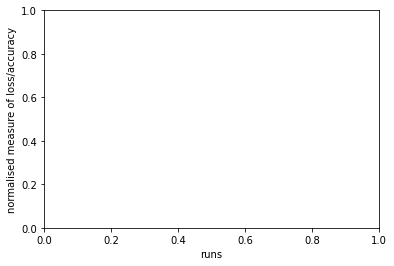

In [141]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show